In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [2]:
%%time
input_data=[]
output_data=[]
test_data=[]
x_test_label=[]
for dirpath, dirnames, filenames in os.walk('./stage1_train'):
    if dirpath[-6:]=='images':
        #print(dirpath)
        input_data.append(dirpath+"/"+filenames[0])
    if dirpath[-5:]=='masks':
        for item in filenames:
            filenames[filenames.index(item)]=dirpath+"/"+item
        output_data.append(filenames)
#len(dirpath)
for dirpath, dirnames, filenames in os.walk('./stage1_test'):
    if dirpath[-6:]=='images':
        test_data.append(dirpath+"/"+filenames[0])
        x_test_label.append(filenames[0][:-4])

CPU times: user 101 ms, sys: 149 ms, total: 250 ms
Wall time: 626 ms


In [3]:
%%time
x_train=[]
new_size=0
for path in input_data:
    img=mpimg.imread(path)
    new_size=max(img.shape[0],img.shape[1],new_size)
    x_train.append(img)
    #plt.imshow(img[:,:,1])

y_train=[]
for ans in output_data:
    tmp=0
    for i in (ans):
        img=mpimg.imread(i)
        tmp+=img
    #plt.imshow(tmp)
    y_train.append(tmp)
    
x_test=[]
x_test_label=[]
for path in test_data:
    img=mpimg.imread(path)
    new_size=max(img.shape[0],img.shape[1],new_size)
    x_test.append(img)
    #plt.imshow(img[:,:,1])

CPU times: user 1min 57s, sys: 9.07 s, total: 2min 6s
Wall time: 2min 15s


In [4]:
%%time
BLACK = [0,0,0,1]
x_train_new=[]
y_train_new=[]
x_test_new=[]

for img1 in x_train:
    origin_height,origin_width=img1.shape[0],img1.shape[1]

    #boundary: top, bottom, left, right
    constant= cv2.copyMakeBorder(img1,0,new_size-origin_height,0,new_size-origin_width,cv2.BORDER_REPLICATE,value=BLACK)
    x_train_new.append(constant)
    
for img1 in y_train:
    origin_height,origin_width=img1.shape[0],img1.shape[1]

    #boundary: top, bottom, left, right
    constant= cv2.copyMakeBorder(img1,0,new_size-origin_height,0,new_size-origin_width,cv2.BORDER_REPLICATE,value=0)
    y_train_new.append(constant)
    

for img1 in x_test:
    origin_height,origin_width=img1.shape[0],img1.shape[1]
    #boundary: top, bottom, left, right
    constant= cv2.copyMakeBorder(img1,0,new_size-origin_height,0,new_size-origin_width,cv2.BORDER_REPLICATE,value=BLACK)
    if constant.shape[2]==3:
        
        constant=np.concatenate((constant,np.zeros((new_size,new_size,1))),axis=2)
    x_test_new.append(constant)

CPU times: user 7.75 s, sys: 9.77 s, total: 17.5 s
Wall time: 18.2 s


In [ ]:

plt.imshow(y_train_new[2])


## CNN model

In [10]:
import keras as K
from keras.layers import Input, Conv2D, MaxPool2D, Deconv2D, UpSampling2D
from keras.models import Model
input_img=Input(shape=(new_size,new_size,4))
conv_1=Conv2D(16,kernel_size=(2,2),activation='relu',padding='same')
maxpool_1=MaxPool2D((2,2))
conv_2=Conv2D(32,kernel_size=(2,2),activation='relu',padding='same')
maxpool_2=MaxPool2D((2,2))
conv_3=Conv2D(64,kernel_size=(2,2),activation='relu',padding='same')
maxpool_3=MaxPool2D((2,2))

deconv_1=Deconv2D(32,kernel_size=(2,2),activation='relu',padding='same')
upsamp_1=UpSampling2D((2,2))
deconv_2=Deconv2D(16,kernel_size=(2,2),activation='relu',padding='same')
upsamp_2=UpSampling2D((2,2))
deconv_3=Deconv2D(4,kernel_size=(2,2),activation='relu',padding='same')
upsamp_3=UpSampling2D((2,2))
deconv_4=Deconv2D(1,kernel_size=(2,2),activation='sigmoid',padding='same')


model=conv_1(input_img)
model=maxpool_1(model)
model=conv_2(model)
model=maxpool_2(model)
#model=conv_3(model)
#model=maxpool_3(model)

#model=deconv_1(model)
#model=upsamp_1(model)
model=deconv_2(model)
model=upsamp_2(model)
model=deconv_3(model)
model=upsamp_3(model)
model=deconv_4(model)

model=Model(input_img,model)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1388, 1388, 4)     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1388, 1388, 16)    272       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 694, 694, 16)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 694, 694, 32)      2080      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 347, 347, 32)      0         
_________________________________________________________________
conv2d_transpose_14 (Conv2DT (None, 347, 347, 16)      2064      
_________________________________________________________________
up_sampling2d_11 (UpSampling (None, 694, 694, 16)      0         
__________

In [11]:
training_x=np.array(x_train_new[:-50]).reshape(-1,new_size,new_size,4)
training_y=np.array(y_train_new[:-50]).reshape(-1,new_size,new_size,1)
validate_x=np.array(x_train_new[-50:]).reshape(-1,new_size,new_size,4)
validate_y=np.array(y_train_new[-50:]).reshape(-1,new_size,new_size,1)

from keras import backend as K
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
model.compile(optimizer = 'adam', 
                   loss = dice_coef_loss, 
                   metrics = [dice_coef, 'acc', 'mse'])

In [18]:
model.fit(x=training_x,y=training_y,epochs=5,validation_data=(validate_x,validate_y),batch_size=32)

Train on 620 samples, validate on 50 samples
Epoch 1/5
620/620 [==============================] - 797s 1s/step - loss: -0.4556 - dice_coef: 0.4556 - acc: 0.7776 - mean_squared_error: 0.2142 - val_loss: -0.3113 - val_dice_coef: 0.3113 - val_acc: 0.7665 - val_mean_squared_error: 0.2256
Epoch 2/5
620/620 [==============================] - 799s 1s/step - loss: -0.4647 - dice_coef: 0.4647 - acc: 0.7788 - mean_squared_error: 0.2147 - val_loss: -0.3103 - val_dice_coef: 0.3103 - val_acc: 0.7630 - val_mean_squared_error: 0.2331
Epoch 3/5
620/620 [==============================] - 818s 1s/step - loss: -0.4611 - dice_coef: 0.4611 - acc: 0.7779 - mean_squared_error: 0.2174 - val_loss: -0.3068 - val_dice_coef: 0.3068 - val_acc: 0.7522 - val_mean_squared_error: 0.2390
Epoch 4/5
620/620 [==============================] - 801s 1s/step - loss: -0.4673 - dice_coef: 0.4673 - acc: 0.7799 - mean_squared_error: 0.2149 - val_loss: -0.2966 - val_dice_coef: 0.2966 - val_acc: 0.7240 - val_mean_squared_error: 0.

In [19]:
import json
from keras.applications import imagenet_utils
model.save_weights('./cnn.h5')

In [20]:
predict=model.predict(training_x)

testing_x=np.array(x_test_new).reshape(-1,new_size,new_size,4)
predict_test=model.predict(testing_x)

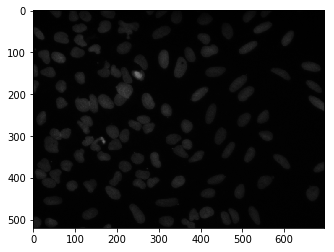

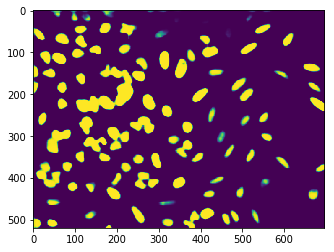

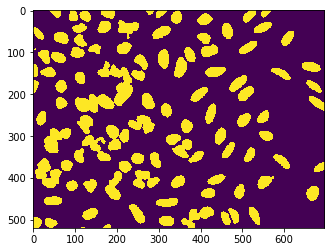

In [29]:
index=7
origin_height,origin_width=x_train[index].shape[0],x_train[index].shape[1]
cropped_pred = predict[index][0:origin_height, 0:origin_width].reshape((origin_height,origin_width))

plt.imshow(x_train[index])
plt.show()
plt.imshow(cropped_pred)
plt.show()
plt.imshow(y_train[index])
plt.show()

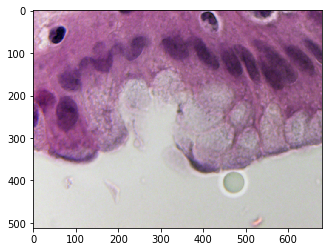

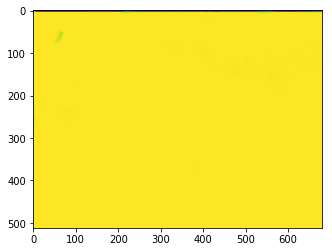

In [26]:
index_test=35
origin_height,origin_width=x_test[index_test].shape[0],x_test[index_test].shape[1]
cropped_pred = predict_test[index_test][0:origin_height, 0:origin_width].reshape((origin_height,origin_width))

plt.imshow(x_test[index_test])
plt.show()
plt.imshow(cropped_pred)
plt.show()